In [1]:
%matplotlib notebook
from hamiltonian.games import BilinearGame, QuadraticGame
from hamiltonian.algorithms import ConsensusOptimization
from hamiltonian.algorithms.lr_scheduler import DecreasingLR
import torch
from enum import Enum
from dataclasses import dataclass
from omegaconf import MISSING, OmegaConf
from typing import Optional
import uuid
import glob
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
import importlib

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size'   : 10,
    "pgf.preamble": [
    "\\usepackage{amsmath}",         # load additional packages
]})

In [2]:
LOG_DIR = "logs_2"

In [3]:
class Game(Enum):
    BILINEAR = "bilinear"
    QUADRATIC = "quadratic"

class Optimizer(Enum):
    CONSENSUS_OPTIMIZATION = "consensus_optimization"
   
@dataclass
class GameConfig:
    name: Game = Game.BILINEAR
    dim: int = 100
    n_samples: int = 100
    mu: Optional[float] = 0.
    L: Optional[float] = 1.
    mu_B: Optional[float] = 0.
    L_B: Optional[float] = 1.
    bias: bool = True
    normal: bool = True
    fixed: bool = False
    
@dataclass
class OptimizerConfig:
    name: Optimizer = Optimizer.CONSENSUS_OPTIMIZATION
    lr: Optional[float] = None
    lr_H: Optional[float] = None
    scheduler: bool = False
    threshold: Optional[int] = None
    same_lr: bool = False
    save_trajectory: bool = False
    lr_ratio: float = 1
    lr_H_ratio: float = 1
         
    
@dataclass
class Config:
    game: GameConfig = GameConfig()
    optimizer: OptimizerConfig = OptimizerConfig()
    n_runs: int = 5
    n_iter: int = 100000
    exp_id: str = MISSING
    partition: Optional[str] = "devlab"
 

def run(args, game=None, init_func=None, save_dir="logs"):
    seed = random.randrange(999999999)
    torch.manual_seed(seed)

    if game is None or not args.game.fixed:
        if args.game.name == Game.BILINEAR:
            game = BilinearGame(args.game.dim, args.game.n_samples, mu_B=args.game.mu_B, L_B=args.game.L_B,
                                bias=args.game.bias, init_func=init_func)
        elif args.game.name == Game.QUADRATIC:
            game = QuadraticGame(args.game.dim, args.game.n_samples, mu=args.game.mu, mu_B=args.game.mu_B,
                                 L=args.game.L, L_B=args.game.L_B, bias=args.game.bias, normal=args.game.normal,
                                init_func=init_func)
        else:
            raise NotImplementedError()

    #print(game.mu, game.ell, game.mu_H, game.L_H)

    lr = args.optimizer.lr
    lr_H = args.optimizer.lr_H
    if args.optimizer.same_lr:
        lr = min(1/(4*game.ell_xi), 1/(4*game.cL_H))
        lr_H = lr
    elif lr is None and lr_H is None:
        lr = 1/(4*game.ell_xi)
        lr_H = 1/(4*game.cL_H)
    elif lr == 0 and lr_H is None:
        lr_H = 1/(2*game.cL_H)
    elif lr is None and lr_H == 0:
        lr = 1/(2*game.ell_xi)

    if lr is not None:
        lr = lr*args.optimizer.lr_ratio
    if lr_H is not None:
        lr_H = lr_H*args.optimizer.lr_H_ratio

    threshold = args.optimizer.threshold 
    if args.optimizer.scheduler and lr_H==0:
        if threshold is None:
            threshold = 4*game.ell_xi/game.mu
        lr = DecreasingLR(lr=lr, threshold=threshold)
    elif args.optimizer.scheduler:
        phi = max(game.ell_xi, game.cL_H)
        if threshold is None:
            threshold = 8*phi/(game.mu+game.mu_H)
        lr = DecreasingLR(lr=1/(4*phi), threshold=threshold)
        lr_H = lr 
        
    print(lr, lr_H)

    if args.optimizer.name == Optimizer.CONSENSUS_OPTIMIZATION:
        save_dir = os.path.join(save_dir, args.exp_id)
        optimizer = ConsensusOptimization(game, lr=lr, lr_H=lr_H, full_batch=False, save_dir=save_dir,
                                          save_trajectory=args.optimizer.save_trajectory)
    optimizer.run(args.n_iter, seed)
    return game, optimizer, config
        
def launch_slurm(args, init_func=None, log_dir='./'):
    shutil.rmtree(os.path.join(log_dir, args.exp_id), ignore_errors=True)
    jobs = []
    
    slurm = True #importlib.util.find_spec("submitit") is not None
    
    if slurm:
        import submitit
        log_folder = "log_test/%j"
        executor = submitit.AutoExecutor(folder=log_folder)
        executor.update_parameters(timeout_min=30, cpus_per_task=8, slurm_partition=args.partition)
        with executor.batch():
            for i in range(args.n_runs):   
                job = executor.submit(run, args, None, init_func, save_dir=log_dir)
                jobs.append(job)
    else:
        for i in range(args.n_runs):
            run(args, None, init_func)
    return jobs
            
def plot(path, normalize=False, key="dist2opt", max_size=None, **kwargs):
    list_runs = glob.glob(path)
    _result = []
    for run_name in list_runs:
        with open(run_name, "r") as f:
            results = json.load(f)
        for k, value in results.items():
            results[k] = np.array(value)
            if normalize and results[k][0] != 0:
                results[k] /= results[k][0]
         
        _result.append(results[key])
        
    n_samples = min([len(r) for r in _result])
    _result = [r[:n_samples] for r in _result]
    
    _result = np.stack(_result, 0)
    
    mean = np.mean(_result, 0)
    ste = np.std(_result, 0)/np.sqrt(len(_result))*1.96
    if key == "x":
        plt.plot(mean[:max_size,0], mean[:max_size,1], **kwargs)
        plt.xlabel(r"$x_0$")
        plt.ylabel(r"$x_1$")
    else:
        plt.plot(mean, **kwargs)
        plt.fill_between(np.arange(len(mean)), mean - ste, mean + ste, alpha=0.2)
        plt.yscale("log")
        plt.xlabel("Number of Iterations")
        plt.ylabel("Distance to optimality")
    
def plot_all(path, normalize=True, key="dist2opt", max_size=None, **kwargs):
    list_runs = glob.glob(path)
    _result = []
    for run_name in list_runs:
        with open(run_name, "r") as f:
            results = json.load(f)
        for k, value in results.items():
            results[k] = np.array(value)
            if normalize:
                results[k] /= results[k][0]
        
        if key == "x":
            plt.plot(results[key][:max_size,0], results[key][:max_size,1], **kwargs)
            plt.xlabel(r"$x_0$")
            plt.ylabel(r"$x_1$")
        else:
            plt.plot(results[key], **kwargs)
            plt.yscale("log")
    
def plot_grad(game_config=GameConfig(), grid=((-1, 1), (-1, 1))):
    if game_config.name == Game.BILINEAR:
        game = BilinearGame(game_config.dim, game_config.n_samples, mu_B=game_config.mu_B, L_B=game_config.L_B,
                                bias=game_config.bias)
    elif game_config.name == Game.QUADRATIC:
        game = QuadraticGame(game_config.dim, game_config.n_samples, mu=game_config.mu, mu_B=game_config.mu_B,
                             L=game_config.L, L_B=game_config.L_B, bias=game_config.bias,
                             normal=game_config.normal)
        
    x = torch.linspace(grid[0][0], grid[0][1], 10)
    y = torch.linspace(grid[1][0], grid[1][1], 10)
    grid_x, grid_y = torch.meshgrid(x, y)
    grid_x = grid_x.contiguous().view(-1)
    grid_y = grid_y.contiguous().view(-1)
    grad = []
    for x, y in zip(grid_x, grid_y):
        game.players[0][0].data = x
        game.players[1][0].data = y
        g = game.grad()
        grad.append((g[0], g[1]))
    grad = -torch.tensor(grad)
    plt.quiver(grid_x, grid_y, grad[:,0], grad[:,1], units='width',color='tab:gray', width=0.002)
    plt.scatter(game.x_star, game.y_star, color="black", marker="*", s=300, label="Equilibrium $x^*$", zorder=100)
    plt.xlim(grid[0])
    plt.ylim(grid[1])
    
def init_func(players):
    players[0][0].data = torch.Tensor([0.5])
    players[1][0].data = torch.Tensor([0.5])   

# Constant Step-Size (small $\kappa_G$)

In [4]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, mu_B=1, bias=True, normal=False)
config.optimizer.lr = 0.
config.n_iter = 50
config.exp_id = "quadratic_1"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [5]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, mu_B=1, bias=True, normal=False)
config.optimizer.lr_H = 0.
config.n_iter = 50
config.exp_id = "quadratic_2"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [6]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, mu_B=1, bias=True, normal=False)
config.n_iter = 50
config.exp_id = "quadratic_3"

jobs = launch_slurm(config, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


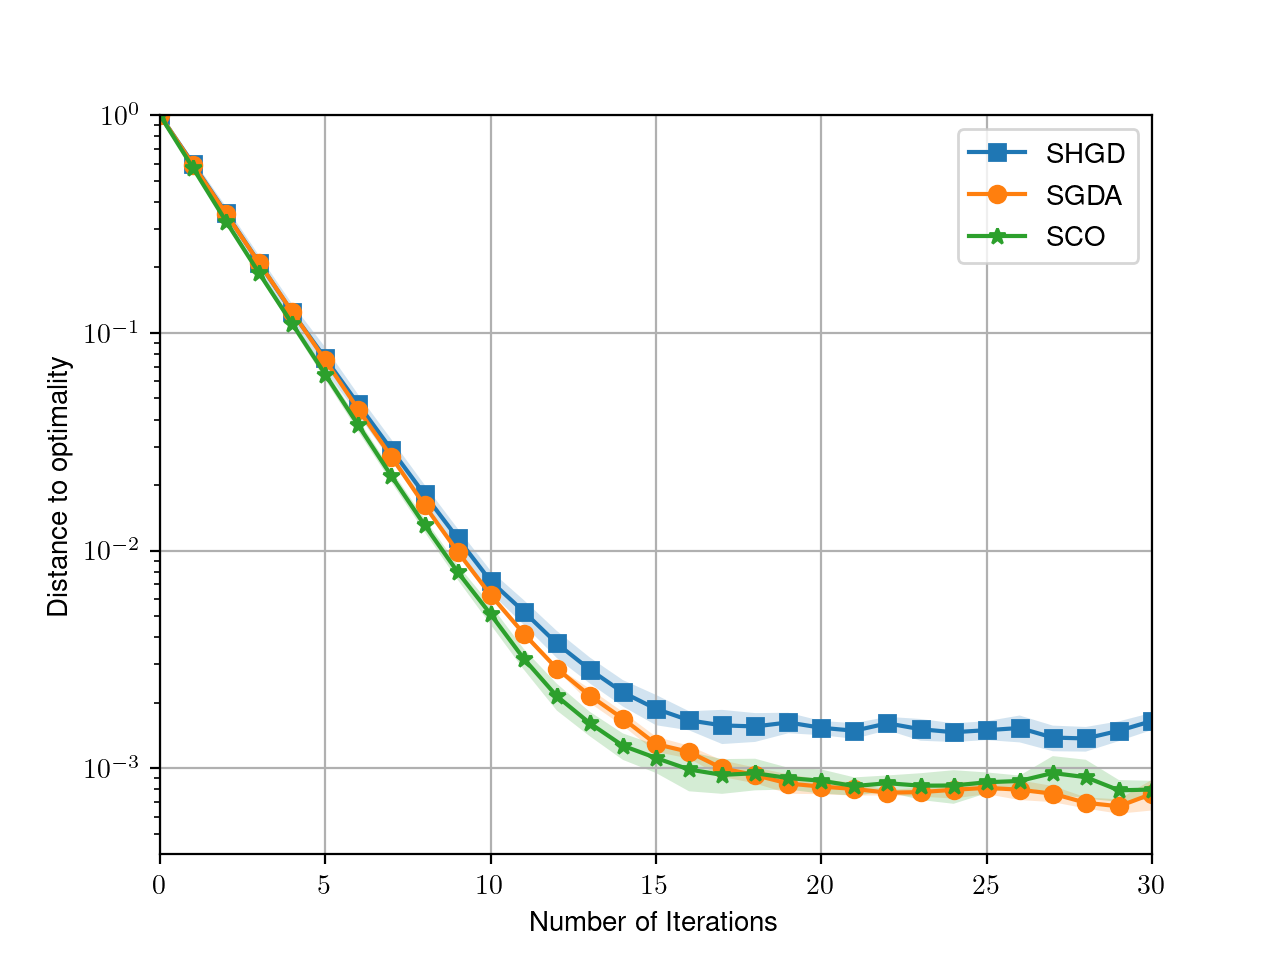

In [51]:
plt.figure()
plot(os.path.join(LOG_DIR, "quadratic_1/*.json"), label="SHGD", marker="s", normalize=True)
plot(os.path.join(LOG_DIR, "quadratic_2/*.json"), label="SGDA", marker="o", normalize=True)
plot(os.path.join(LOG_DIR, "quadratic_3/*.json"), label="SCO", marker="*", normalize=True)
plt.legend()
plt.xlim(0, 30)
plt.ylim(top=1)
plt.grid()
plt.savefig("figures/quadratic_small_kappa.pdf", format='pdf', bbox_inches='tight')

# Constant Step-Size (Medium $\kappa_G$)

In [7]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=5e-1, L=5e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr = 0.
config.n_iter = 100
config.exp_id = "quadratic_large_1"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [8]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=5e-1, L=5e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_H = 0.
config.n_iter = 100
config.exp_id = "quadratic_large_2"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [9]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=5e-1, L=5e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.n_iter = 100
config.exp_id = "quadratic_large_3"

jobs = launch_slurm(config, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


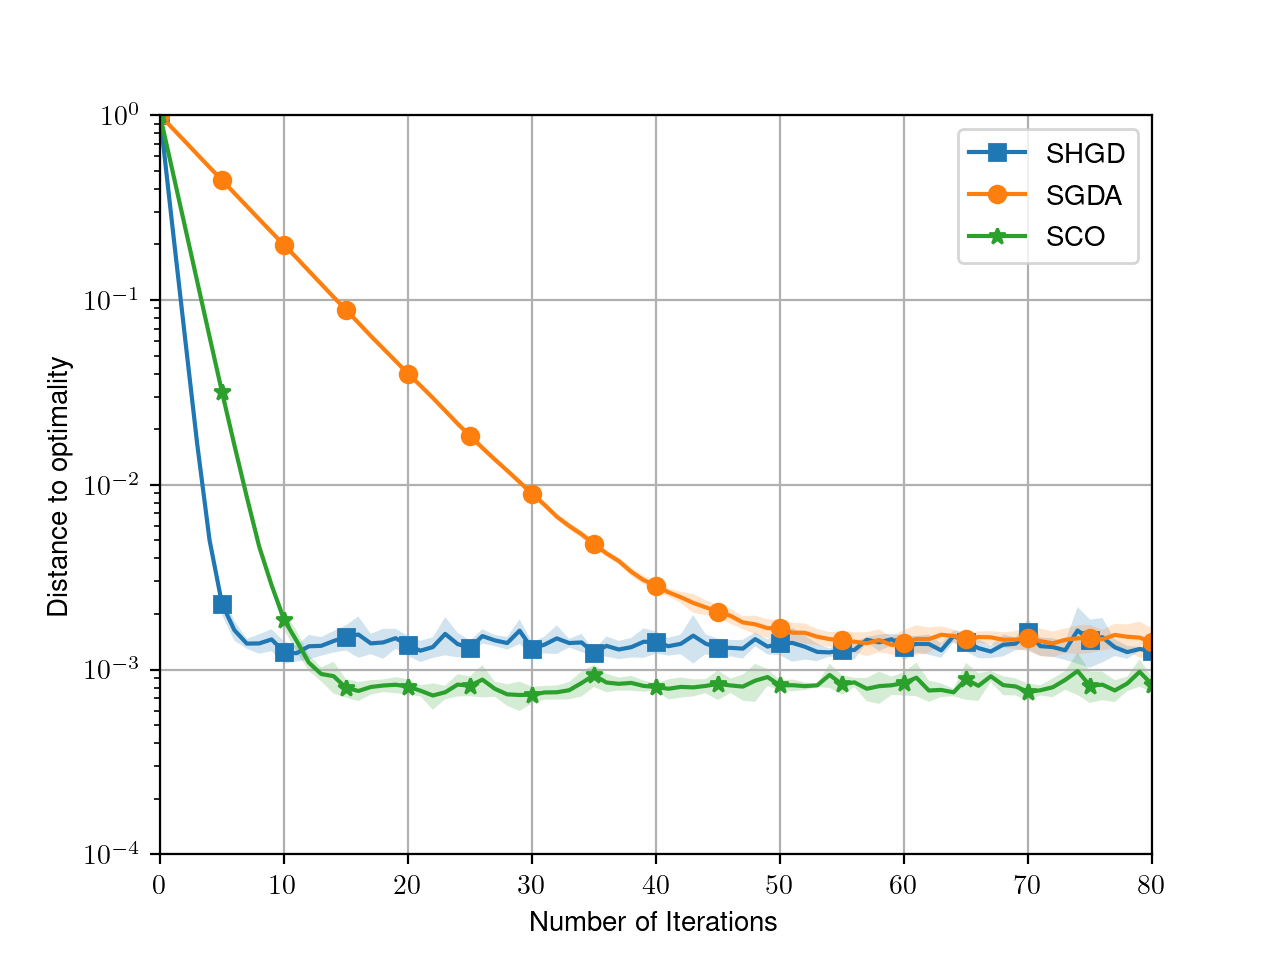

In [52]:
plt.figure()
plot(os.path.join(LOG_DIR, "quadratic_large_1/*.json"), label="SHGD", marker="s", markevery=5, normalize=True)
plot(os.path.join(LOG_DIR, "quadratic_large_2/*.json"), label="SGDA", marker="o", markevery=5, normalize=True)
plot(os.path.join(LOG_DIR, "quadratic_large_3/*.json"), label="SCO", marker="*", markevery=5, normalize=True)
plt.legend()
plt.xlim(0, 80)
plt.ylim(1e-4, 1)
plt.grid()
plt.savefig("figures/quadratic_medium_kappa.pdf", format='pdf', bbox_inches='tight')

# Constant Step-Size (Large $\kappa_G$)

In [10]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=2e-1, L=2e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr = 0.
config.n_iter = 1000
config.exp_id = "quadratic_vlarge_1"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [11]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=2e-1, L=2e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_H = 0
config.n_iter = 1000
config.exp_id = "quadratic_vlarge_2"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [12]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=2e-1, L=2e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.n_iter = 1000
config.exp_id = "quadratic_vlarge_3"

jobs = launch_slurm(config, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


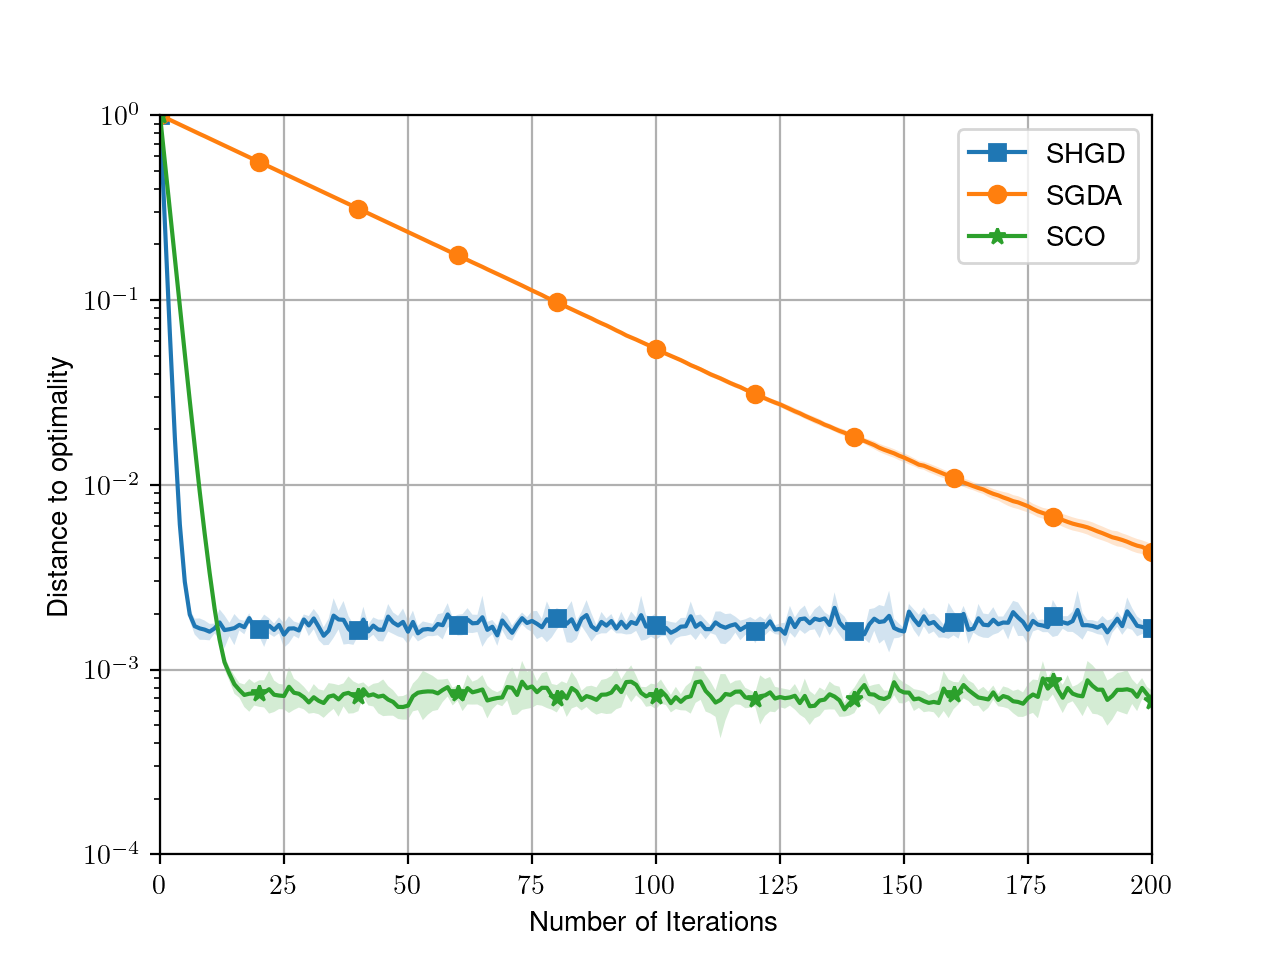

In [53]:
plt.figure()
plot(os.path.join(LOG_DIR, "quadratic_vlarge_1/*.json"), label="SHGD", marker="s", markevery=20, normalize=True)
plot(os.path.join(LOG_DIR, "quadratic_vlarge_2/*.json"), label="SGDA", marker="o", markevery=20, normalize=True)
plot(os.path.join(LOG_DIR, "quadratic_vlarge_3/*.json"), label="SCO", marker="*", markevery=20, normalize=True)
plt.legend()
plt.xlim(0, 200)
plt.ylim(1e-4, 1)
plt.grid()
plt.savefig("figures/quadratic_large_kappa.pdf", format='pdf', bbox_inches='tight')

# Decreasing Step Size: SCO

In [13]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1e-1, L=1e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.scheduler = True
config.n_iter = 10000
config.exp_id = "quadratic_sco_1"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [14]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1e-1, L=1e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.scheduler = False
config.optimizer.same_lr = True
config.n_iter = 10000
config.exp_id = "quadratic_sco_2"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [15]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1e-1, L=1e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.scheduler = True
config.optimizer.same_lr = True
config.optimizer.threshold = 100
config.n_iter = 10000
config.exp_id = "quadratic_sco_3"

jobs = launch_slurm(config, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


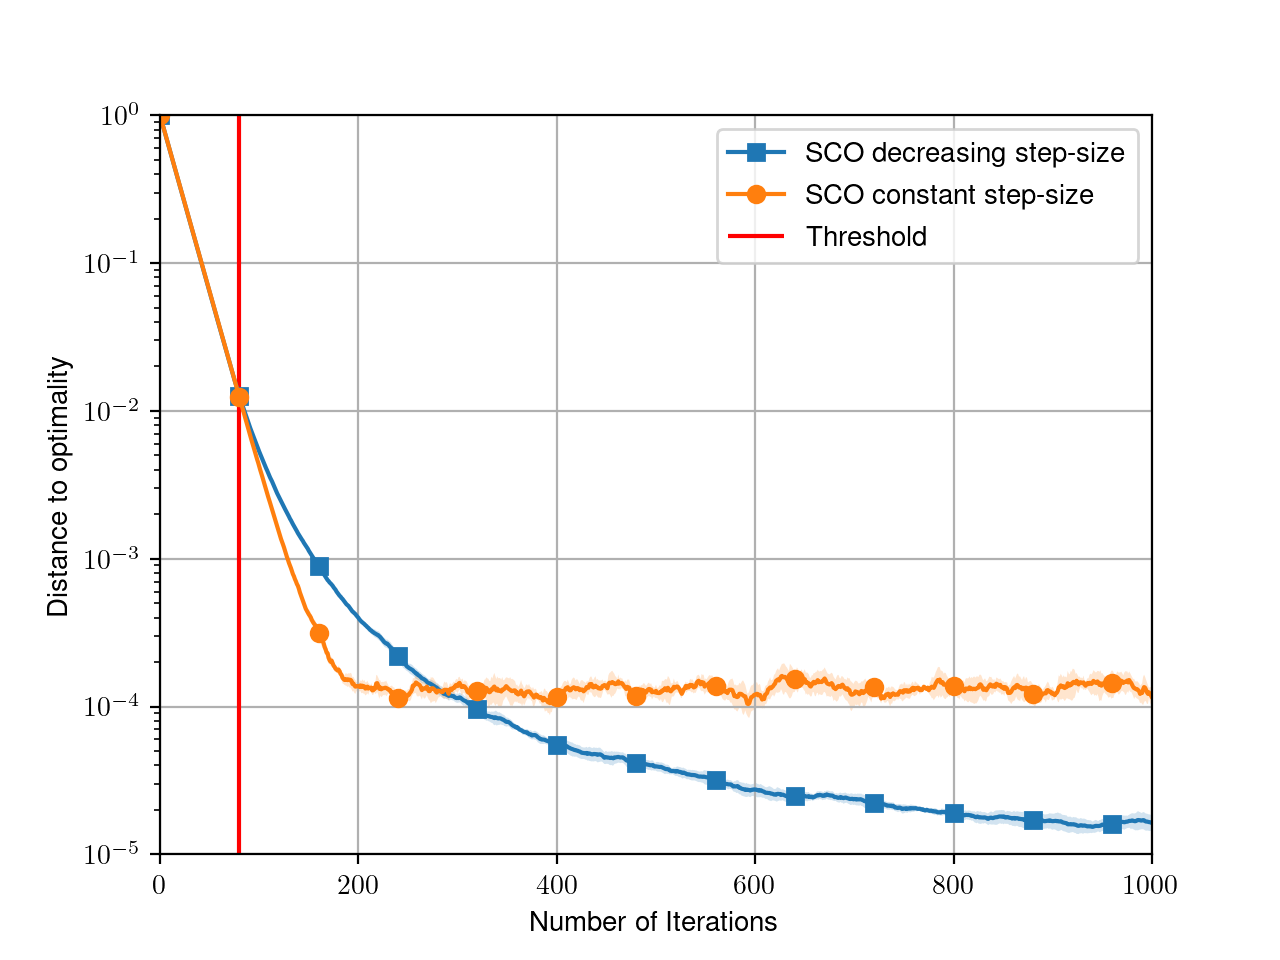

In [65]:
plt.figure()
plot(os.path.join(LOG_DIR, "quadratic_sco_1/*.json"), label="SCO decreasing step-size", marker="s", markevery=80, normalize=True)
plot(os.path.join(LOG_DIR, "quadratic_sco_2/*.json"), label="SCO constant step-size", marker="o", markevery=80, normalize=True)
plt.vlines(80, ymin=1e-5, ymax=1e0, color="red", label="Threshold")
plt.legend()
plt.xlim(0,1000)
plt.ylim(1e-5, 1)
plt.grid()
plt.savefig("figures/quadratic_sco.pdf", format='pdf', bbox_inches='tight')

# Decreasing Step-Size: SGDA

In [16]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1e-1, L=1e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.scheduler = True
config.optimizer.lr_H = 0.
config.n_iter = 10000
config.exp_id = "quadratic_sgda_1"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [17]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1e-1, L=1e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.scheduler = False
config.optimizer.lr_H = 0.
config.n_iter = 10000
config.exp_id = "quadratic_sgda_2"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [18]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1e-1, L=1e-1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.scheduler = True
config.optimizer.lr_H = 0.
config.optimizer.threshold = 600
config.n_iter = 10000
config.exp_id = "quadratic_sgda_3"

jobs = launch_slurm(config, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


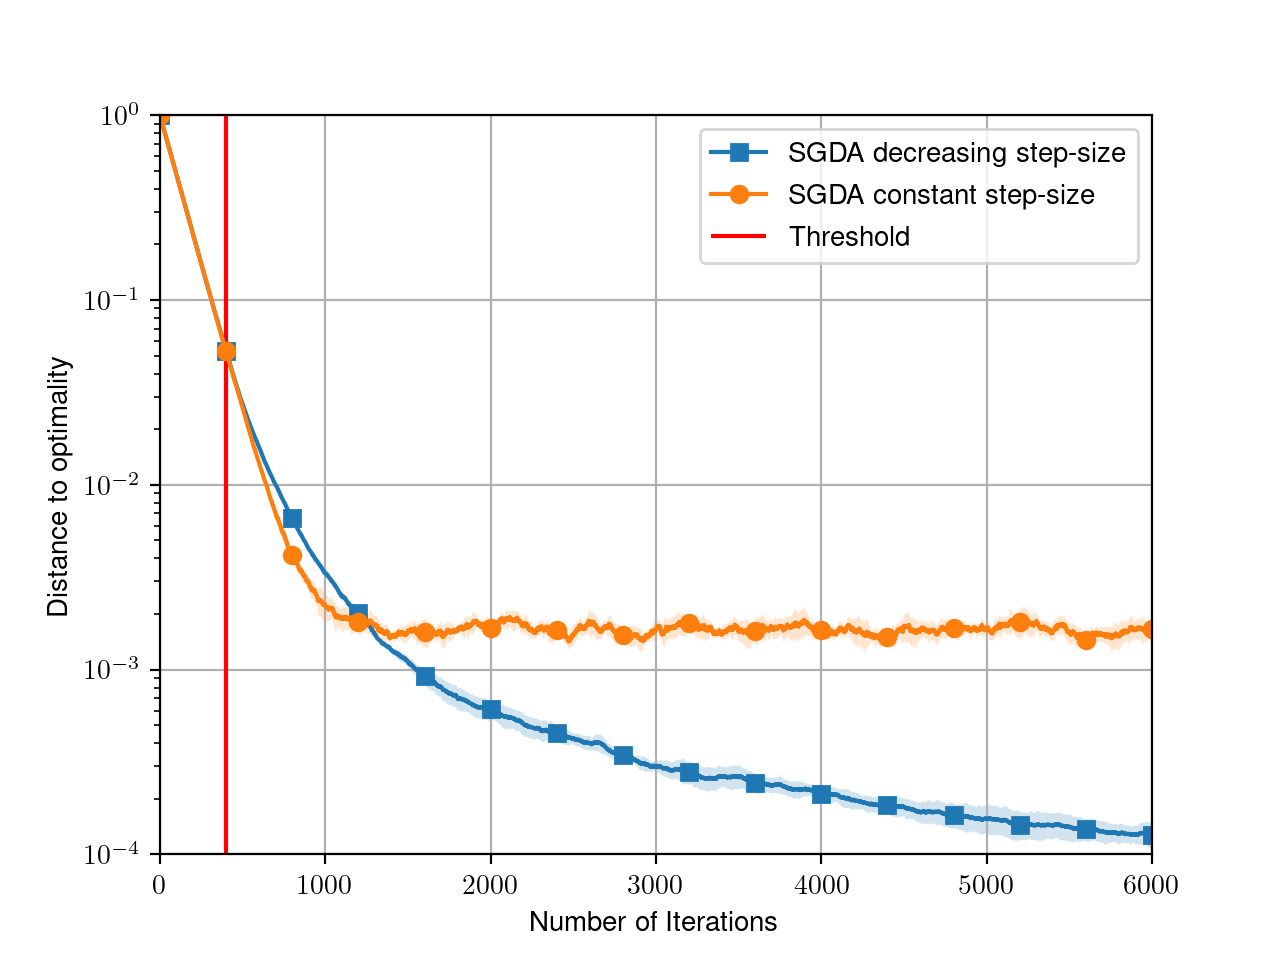

In [66]:
plt.figure()
plot(os.path.join(LOG_DIR, "quadratic_sgda_1/*.json"), label="SGDA decreasing step-size", marker="s", markevery=400, normalize=True)
plot(os.path.join(LOG_DIR, "quadratic_sgda_2/*.json"), label="SGDA constant step-size", marker="o", markevery=400, normalize=True)
plt.xlim(0,6000)
plt.ylim(1e-4, 1e0)
plt.vlines(400, ymin=1e-4, ymax=1e0, color="red", label="Threshold")
plt.grid()
plt.legend()
plt.savefig("figures/quadratic_sgda.pdf", format='pdf', bbox_inches='tight')

# 2d Trajectory plot

## Small $\kappa_G$

In [19]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=False, dim=1, fixed=True)
config.optimizer.lr = 0.
config.optimizer.save_trajectory = True
config.n_iter = 50
config.exp_id = "2d_small_1"

games = launch_slurm(config, init_func=init_func, log_dir=LOG_DIR)

In [20]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=False, dim=1, fixed=True)
config.optimizer.lr_H = 0.
config.optimizer.save_trajectory = True
config.n_iter = 50
config.exp_id = "2d_small_2"

games = launch_slurm(config, init_func=init_func, log_dir=LOG_DIR)

In [21]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=False, dim=1, fixed=True)
config.optimizer.save_trajectory = True
config.n_iter = 50
config.exp_id = "2d_small_3"

games = launch_slurm(config, init_func=init_func, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


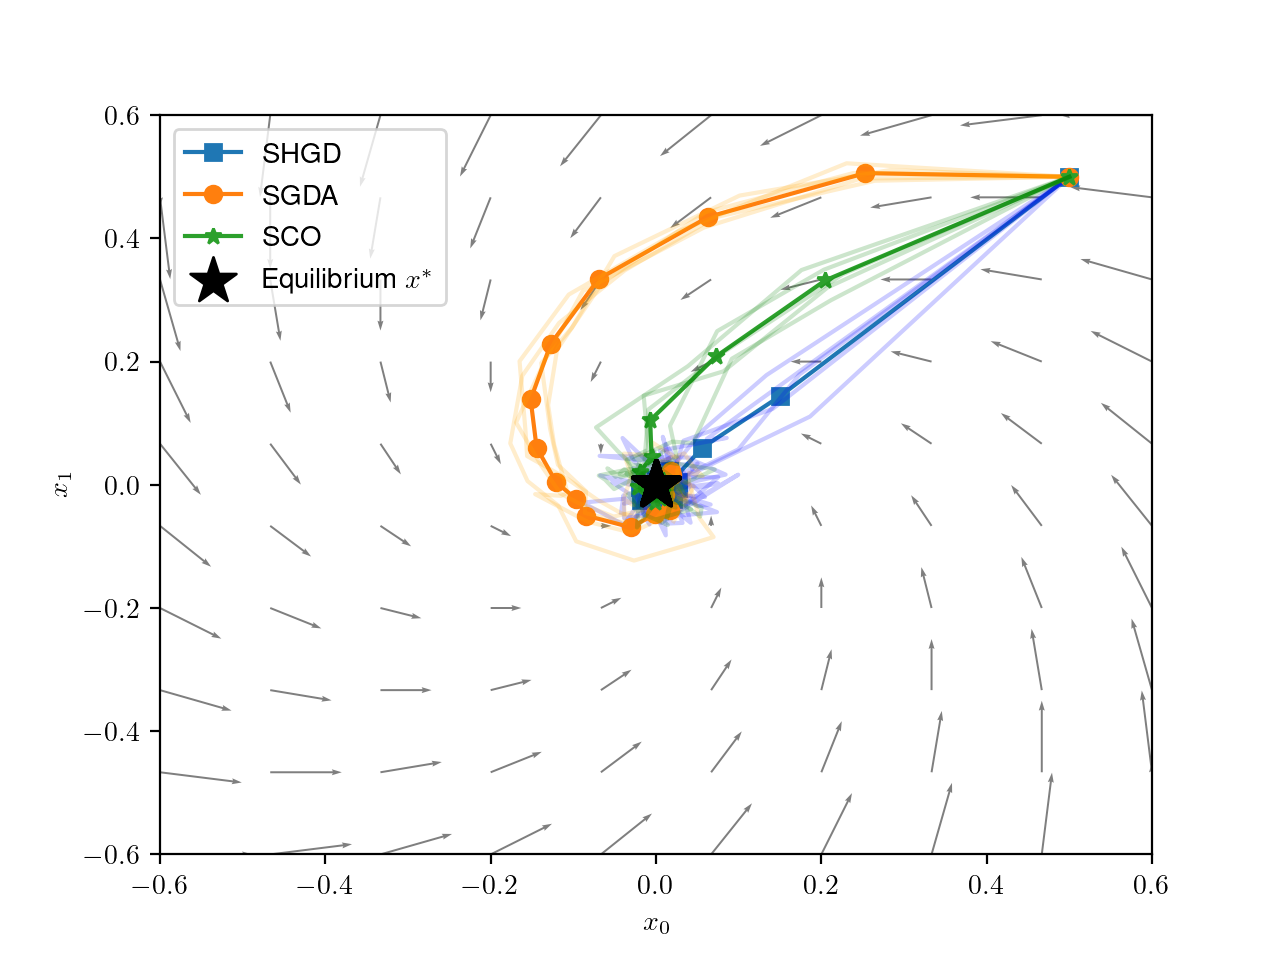

/private/home/hberard/Projects/momentum-hamiltonian/hamiltonian/games/utils.py:19: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1940.)
  Q, _ = torch.qr(A)


In [58]:
plt.figure()
grid = ((-0.6, 0.6), (-0.6, 0.6))
game_config = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
plot_grad(game_config, grid=grid)
plot("logs/2d_small_1/*.json", normalize=False, key="x", label="SHGD", marker="s", max_size=20)
plot_all("logs/2d_small_1/*.json", normalize=False, key="x", color="blue", alpha=0.2, max_size=20)
plot("logs/2d_small_2/*.json", normalize=False, key="x", label="SGDA", marker="o", max_size=20)
plot_all("logs/2d_small_2/*.json", normalize=False, key="x", color="orange", alpha=0.2, max_size=20)
plot("logs/2d_small_3/*.json", normalize=False, key="x", label="SCO", marker="*", max_size=20)
plot_all("logs/2d_small_3/*.json", normalize=False, key="x", color="green", alpha=0.2, max_size=20)
plt.legend()
plt.savefig("figures/2d_small.pdf", format='pdf', bbox_inches='tight')

## Large $\kappa_G$

In [22]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=3e-1, L=3e-1, mu_B=1, L_B=1, bias=True, normal=False, dim=1, fixed=True)
config.optimizer.lr = 0.
config.optimizer.scheduler
config.optimizer.save_trajectory = True
config.n_iter = 500
config.exp_id = "2d_large_1"

games = launch_slurm(config, init_func=init_func, log_dir=LOG_DIR)

In [23]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=3e-1, L=3e-1, mu_B=1, L_B=1, bias=True, normal=False, dim=1, fixed=True)
config.optimizer.lr_H = 0.
config.optimizer.save_trajectory = True
config.n_iter = 500
config.exp_id = "2d_large_2"

games = launch_slurm(config, init_func=init_func, log_dir=LOG_DIR)

In [24]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=3e-1, L=3e-1, mu_B=1, L_B=1, bias=True, normal=False, dim=1, fixed=True)
config.optimizer.save_trajectory = True
config.n_iter = 500
config.exp_id = "2d_large_3"

games = launch_slurm(config, init_func=init_func, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


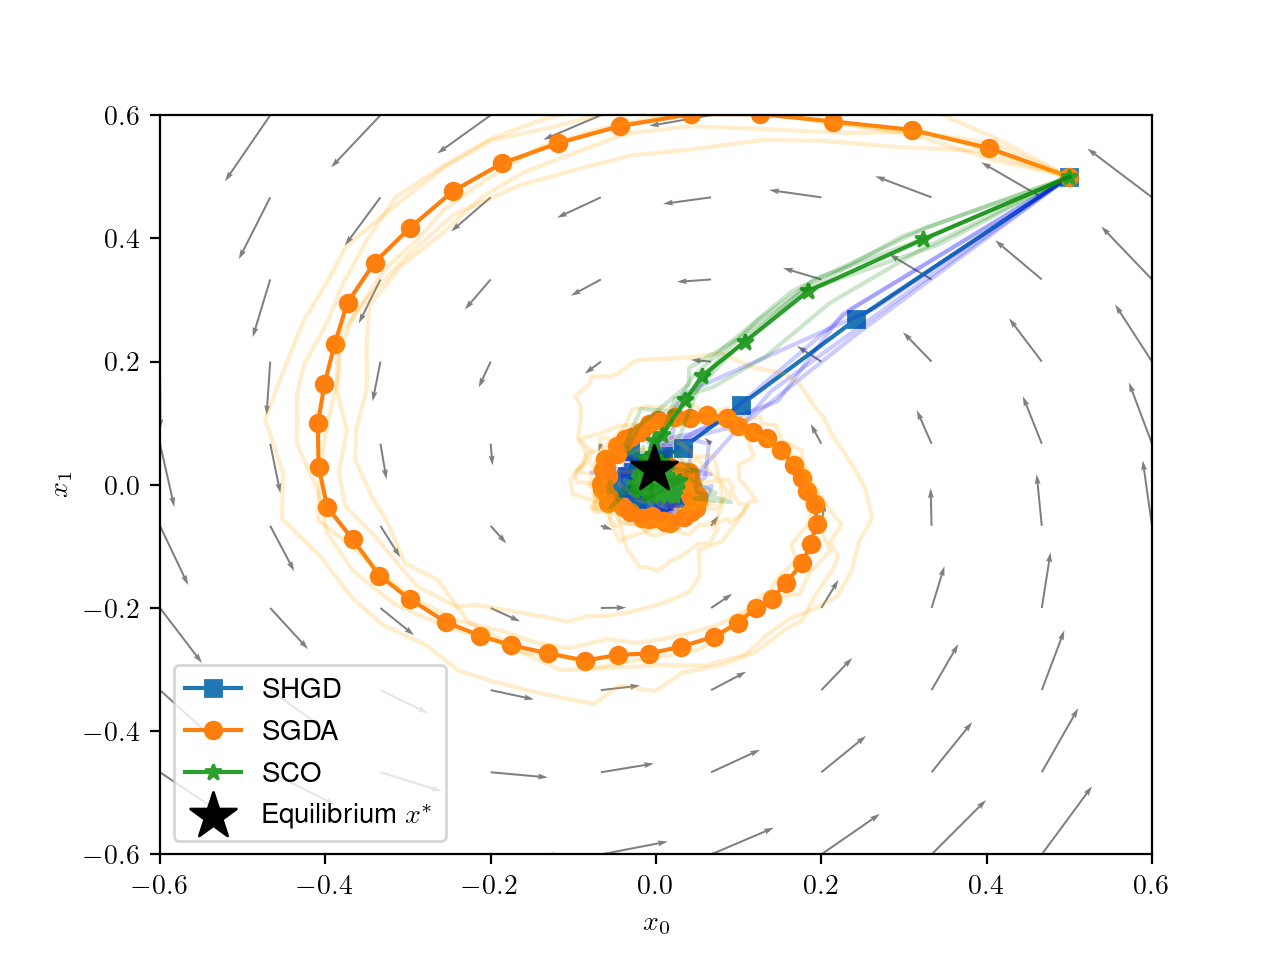

In [59]:
plt.figure()
grid = ((-0.6, 0.6), (-0.6, 0.6))
game_config = GameConfig(name=Game.QUADRATIC, mu=3e-1, L=3e-1, mu_B=1, L_B=1, bias=True, normal=False, dim=1, fixed=True)
plot_grad(game_config, grid=grid)
plot("logs/2d_large_1/*.json", normalize=False, key="x", label="SHGD", marker="s", max_size=100)
plot_all("logs/2d_large_1/*.json", normalize=False, key="x", color="blue", alpha=0.2, max_size=20)
plot("logs/2d_large_2/*.json", normalize=False, key="x", label="SGDA", marker="o", max_size=100)
plot_all("logs/2d_large_2/*.json", normalize=False, key="x", color="orange", alpha=0.2, max_size=100)
plot("logs/2d_large_3/*.json", normalize=False, key="x", label="SCO", marker="*", max_size=100)
plot_all("logs/2d_large_3/*.json", normalize=False, key="x", color="green", alpha=0.2, max_size=20)

plt.legend()
plt.savefig("figures/2d_large.pdf", format='pdf', bbox_inches='tight')

# Grid Search

## Small $\kappa_G$, SHGD

In [25]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr = 0.
config.optimizer.lr_H_ratio = 1.
config.n_iter = 50
config.exp_id = "SHGD_small_1"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [26]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr = 0.
config.optimizer.lr_H_ratio = 1.5
config.n_iter = 50
config.exp_id = "SHGD_small_2"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [27]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr = 0.
config.optimizer.lr_H_ratio = 2.
config.n_iter = 50
config.exp_id = "SHGD_small_3"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [28]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr = 0.
config.optimizer.lr_H_ratio = 1/1.5
config.n_iter = 50
config.exp_id = "SHGD_small_4"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [29]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr = 0.
config.optimizer.lr_H_ratio = 1/2
config.n_iter = 50
config.exp_id = "SHGD_small_5"

jobs = launch_slurm(config, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


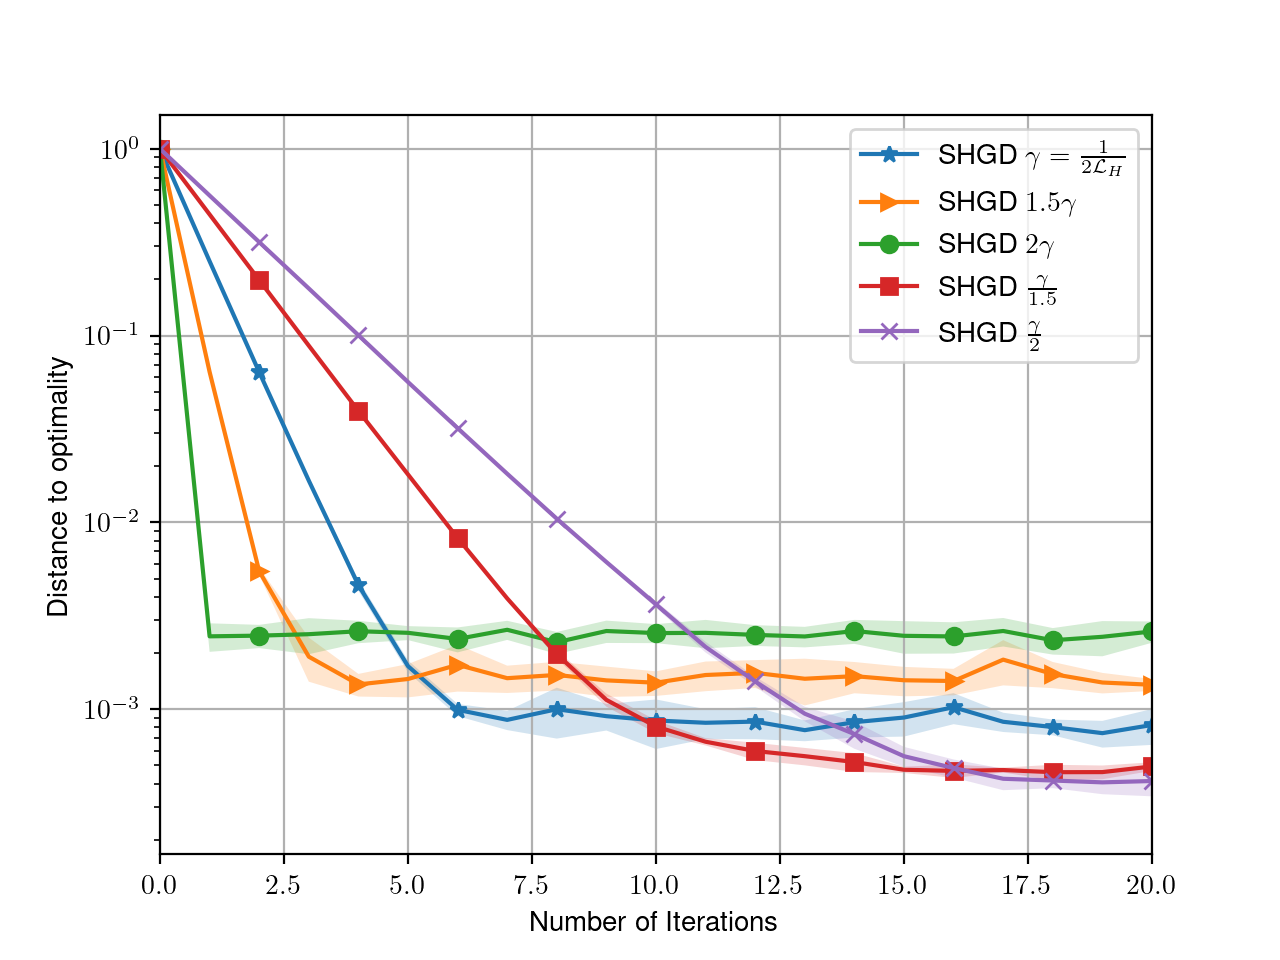

In [60]:
plt.figure()
plot(os.path.join(LOG_DIR, "SHGD_small_1/*.json"), label=r"SHGD $\gamma = \frac{1}{2\mathcal{L}_H}$", marker="*", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SHGD_small_2/*.json"), label=r"SHGD $1.5\gamma$", marker=">", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SHGD_small_3/*.json"), label=r"SHGD $2\gamma$", marker="o", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SHGD_small_4/*.json"), label=r"SHGD $\frac{\gamma}{1.5}$", marker="s", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SHGD_small_5/*.json"), label=r"SHGD $\frac{\gamma}{2}$", marker="x", markevery=2, normalize=True)

plt.legend()
plt.xlim(0, 20)
#plt.ylim(top=1)
plt.grid()
plt.savefig("figures/shgd_lr.pdf", format='pdf', bbox_inches='tight')

## SGDA small $\kappa_G$

In [30]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_H = 0.
config.optimizer.lr_ratio = 1.
config.n_iter = 50
config.exp_id = "SGDA_small_1"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [31]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_H = 0.
config.optimizer.lr_ratio = 3
config.n_iter = 50
config.exp_id = "SGDA_small_2"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [32]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_H = 0.
config.optimizer.lr_ratio = 2
config.n_iter = 50
config.exp_id = "SGDA_small_3"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [33]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_H = 0.
config.optimizer.lr_ratio = 1/3
config.n_iter = 50
config.exp_id = "SGDA_small_4"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [34]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_H = 0.
config.optimizer.lr_ratio = 1/2
config.n_iter = 50
config.exp_id = "SGDA_small_5"

jobs = launch_slurm(config, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


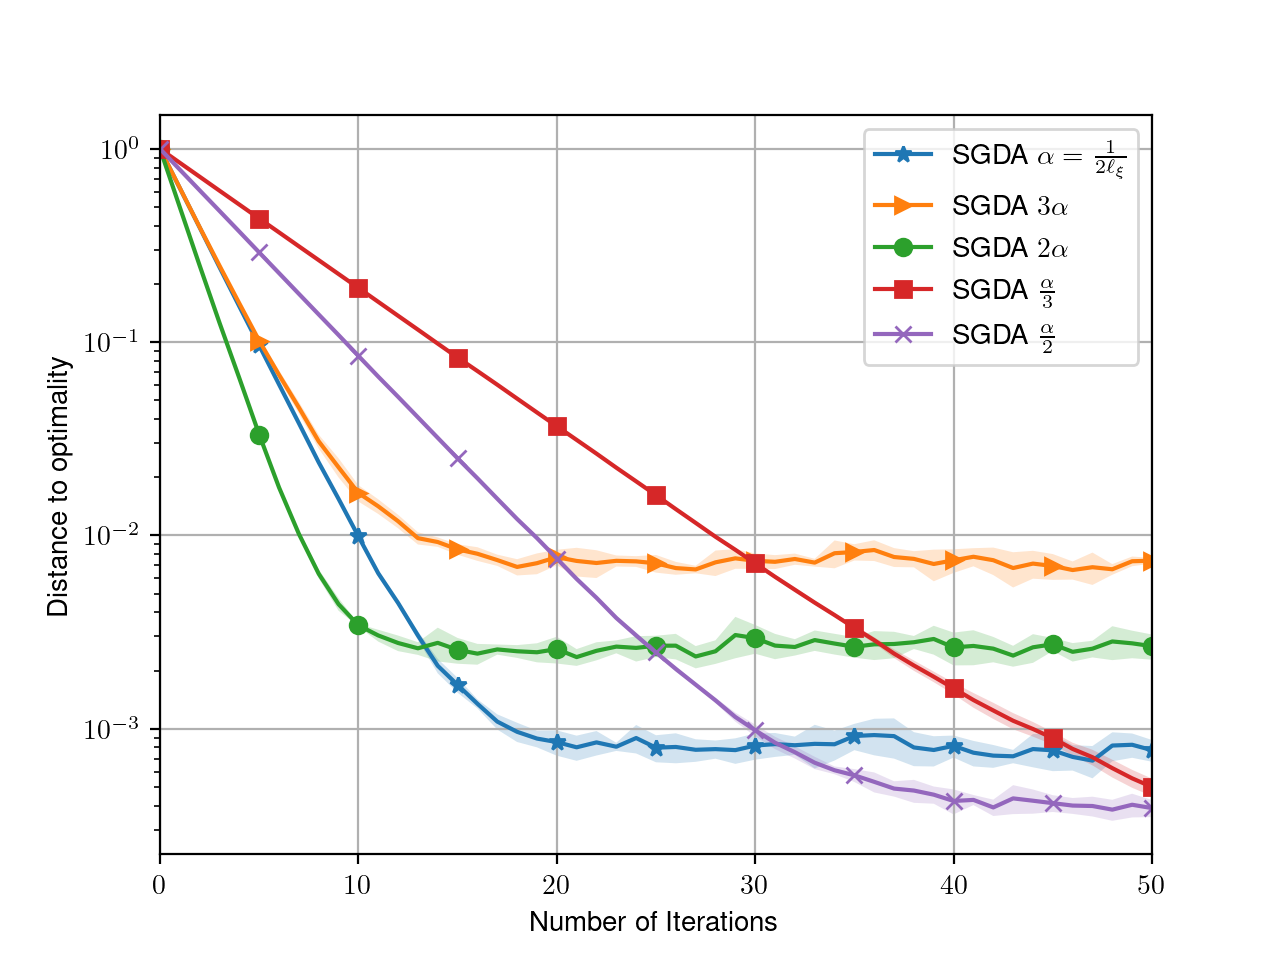

In [61]:
plt.figure()
plot(os.path.join(LOG_DIR, "SGDA_small_1/*.json"), label=r"SGDA $\alpha = \frac{1}{2\ell_\xi}$", marker="*", markevery=5, normalize=True)
plot(os.path.join(LOG_DIR, "SGDA_small_2/*.json"), label=r"SGDA $3\alpha$", marker=">", markevery=5, normalize=True)
plot(os.path.join(LOG_DIR, "SGDA_small_3/*.json"), label=r"SGDA $2\alpha$", marker="o", markevery=5, normalize=True)
plot(os.path.join(LOG_DIR, "SGDA_small_4/*.json"), label=r"SGDA $\frac{\alpha}{3}$", marker="s", markevery=5, normalize=True)
plot(os.path.join(LOG_DIR, "SGDA_small_5/*.json"), label=r"SGDA $\frac{\alpha}{2}$", marker="x", markevery=5, normalize=True)

plt.legend()
plt.xlim(0, 50)
#plt.ylim(top=1)
plt.grid()
plt.savefig("figures/sgda_lr.pdf", format='pdf', bbox_inches='tight')

## SCO small $\kappa_G$

In [35]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 1.
config.optimizer.lr_H_ratio = 1.
config.n_iter = 50
config.exp_id = "SCO_small_1"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [36]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 2
config.optimizer.lr_H_ratio = 2
config.n_iter = 50
config.exp_id = "SCO_small_2"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [37]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 3
config.optimizer.lr_H_ratio = 3
config.n_iter = 50
config.exp_id = "SCO_small_3"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [38]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 1/3
config.optimizer.lr_H_ratio = 1/3
config.n_iter = 50
config.exp_id = "SCO_small_4"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [39]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 1/2
config.optimizer.lr_H_ratio = 1/2
config.n_iter = 50
config.exp_id = "SCO_small_5"

jobs = launch_slurm(config, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


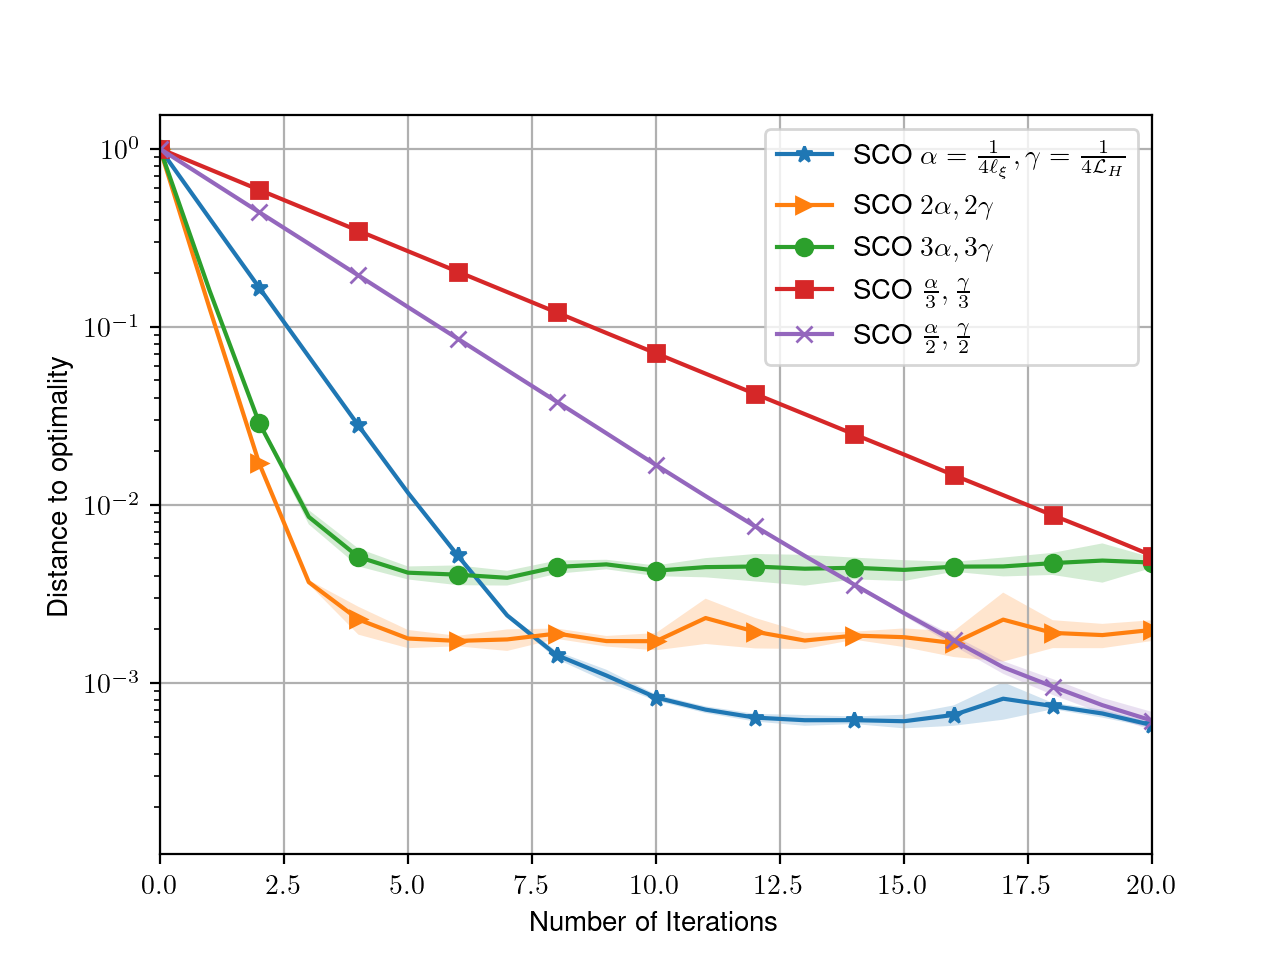

In [62]:
plt.figure()
plot(os.path.join(LOG_DIR, "SCO_small_1/*.json"), label=r"SCO $\alpha=\frac{1}{4\ell_\xi}, \gamma = \frac{1}{4\mathcal{L}_H}$", marker="*", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_small_2/*.json"), label=r"SCO $2\alpha, 2\gamma$", marker=">", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_small_3/*.json"), label=r"SCO $3\alpha, 3\gamma$", marker="o", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_small_4/*.json"), label=r"SCO $\frac{\alpha}{3}, \frac{\gamma}{3}$", marker="s", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_small_5/*.json"), label=r"SCO $\frac{\alpha}{2}, \frac{\gamma}{2}$", marker="x", markevery=2, normalize=True)

plt.legend()
plt.xlim(0, 20)
#plt.ylim(top=1)
plt.grid()
plt.savefig("figures/sco_gamma_alpha.pdf", format='pdf', bbox_inches='tight')

## SCO ($\gamma$ search) small $\kappa_G$

In [40]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 1
config.optimizer.lr_H_ratio = 1.
config.n_iter = 50
config.exp_id = "SCO_gamma_small_1"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [41]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 1
config.optimizer.lr_H_ratio = 2
config.n_iter = 50
config.exp_id = "SCO_gamma_small_2"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [42]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 1
config.optimizer.lr_H_ratio = 4
config.n_iter = 50
config.exp_id = "SCO_gamma_small_3"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [43]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 1
config.optimizer.lr_H_ratio = 1/3
config.n_iter = 50
config.exp_id = "SCO_gamma_small_4"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [44]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 1
config.optimizer.lr_H_ratio = 1/2
config.n_iter = 50
config.exp_id = "SCO_gamma_small_5"

jobs = launch_slurm(config, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


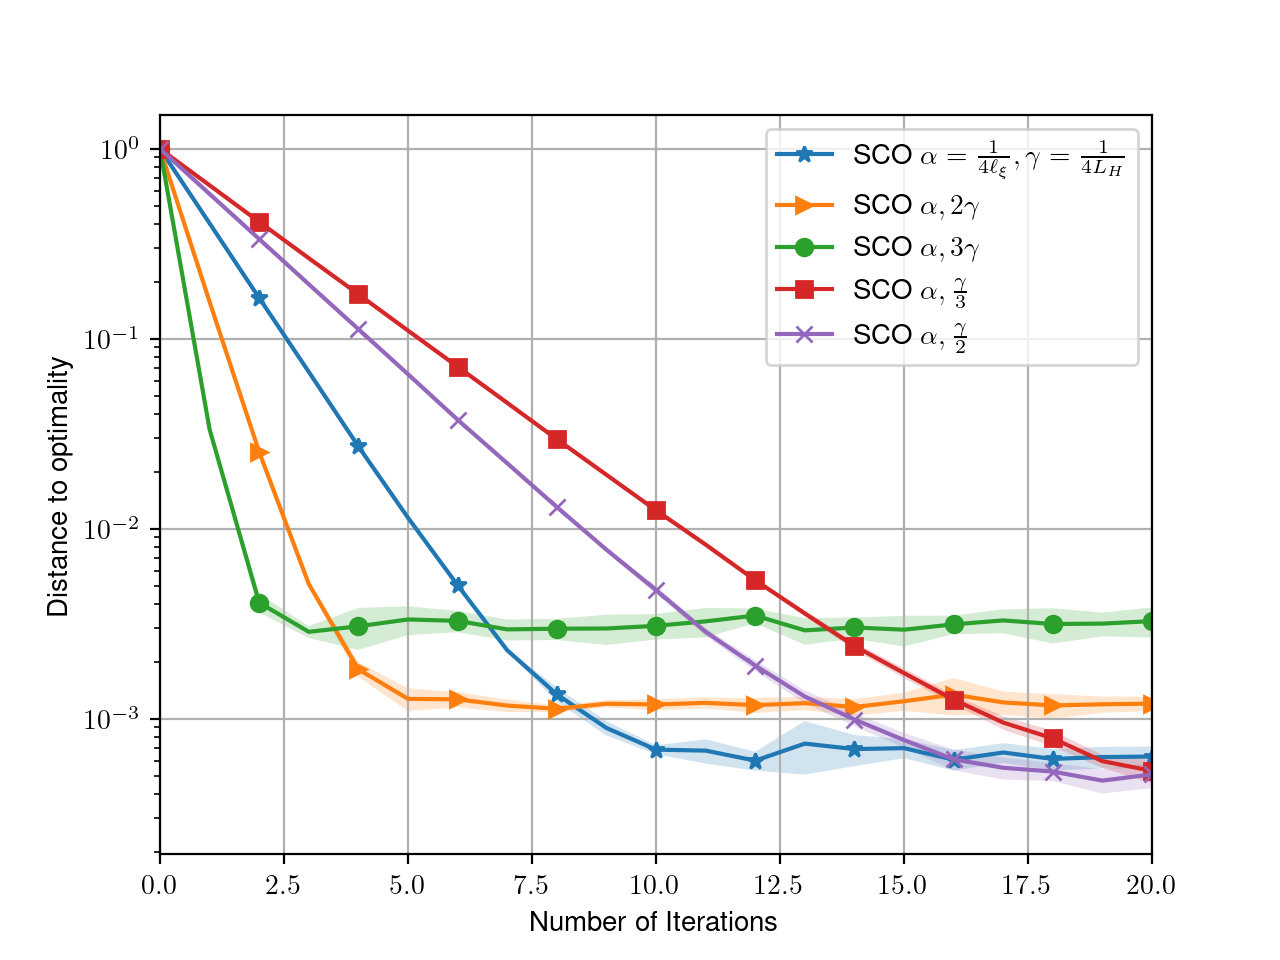

In [63]:
plt.figure()
plot(os.path.join(LOG_DIR, "SCO_gamma_small_1/*.json"), label=r"SCO $\alpha=\frac{1}{4\ell_\xi}, \gamma = \frac{1}{4L_H}$", marker="*", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_gamma_small_2/*.json"), label=r"SCO $\alpha, 2\gamma$", marker=">", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_gamma_small_3/*.json"), label=r"SCO $\alpha, 3\gamma$", marker="o", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_gamma_small_4/*.json"), label=r"SCO $\alpha, \frac{\gamma}{3}$", marker="s", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_gamma_small_5/*.json"), label=r"SCO $\alpha, \frac{\gamma}{2}$", marker="x", markevery=2, normalize=True)

plt.legend()
plt.xlim(0, 20)
#plt.ylim(top=1)
plt.grid()
plt.savefig("figures/sco_gamma.pdf", format='pdf', bbox_inches='tight')

## SCO ($\alpha$ search) small $\kappa_G$

In [45]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 1
config.optimizer.lr_H_ratio = 1.
config.n_iter = 50
config.exp_id = "SCO_alpha_small_1"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [46]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 2
config.optimizer.lr_H_ratio = 1
config.n_iter = 50
config.exp_id = "SCO_alpha_small_2"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [47]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 5
config.optimizer.lr_H_ratio = 1
config.n_iter = 50
config.exp_id = "SCO_alpha_small_3"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [48]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 1/5
config.optimizer.lr_H_ratio = 1
config.n_iter = 50
config.exp_id = "SCO_alpha_small_4"

jobs = launch_slurm(config, log_dir=LOG_DIR)

In [49]:
config = OmegaConf.structured(Config())
config.game = GameConfig(name=Game.QUADRATIC, mu=1, L=1, mu_B=1, L_B=1, bias=True, normal=True)
config.optimizer.lr_ratio = 1/2
config.optimizer.lr_H_ratio = 1
config.n_iter = 50
config.exp_id = "SCO_alpha_small_5"

jobs = launch_slurm(config, log_dir=LOG_DIR)

<IPython.core.display.Javascript object>


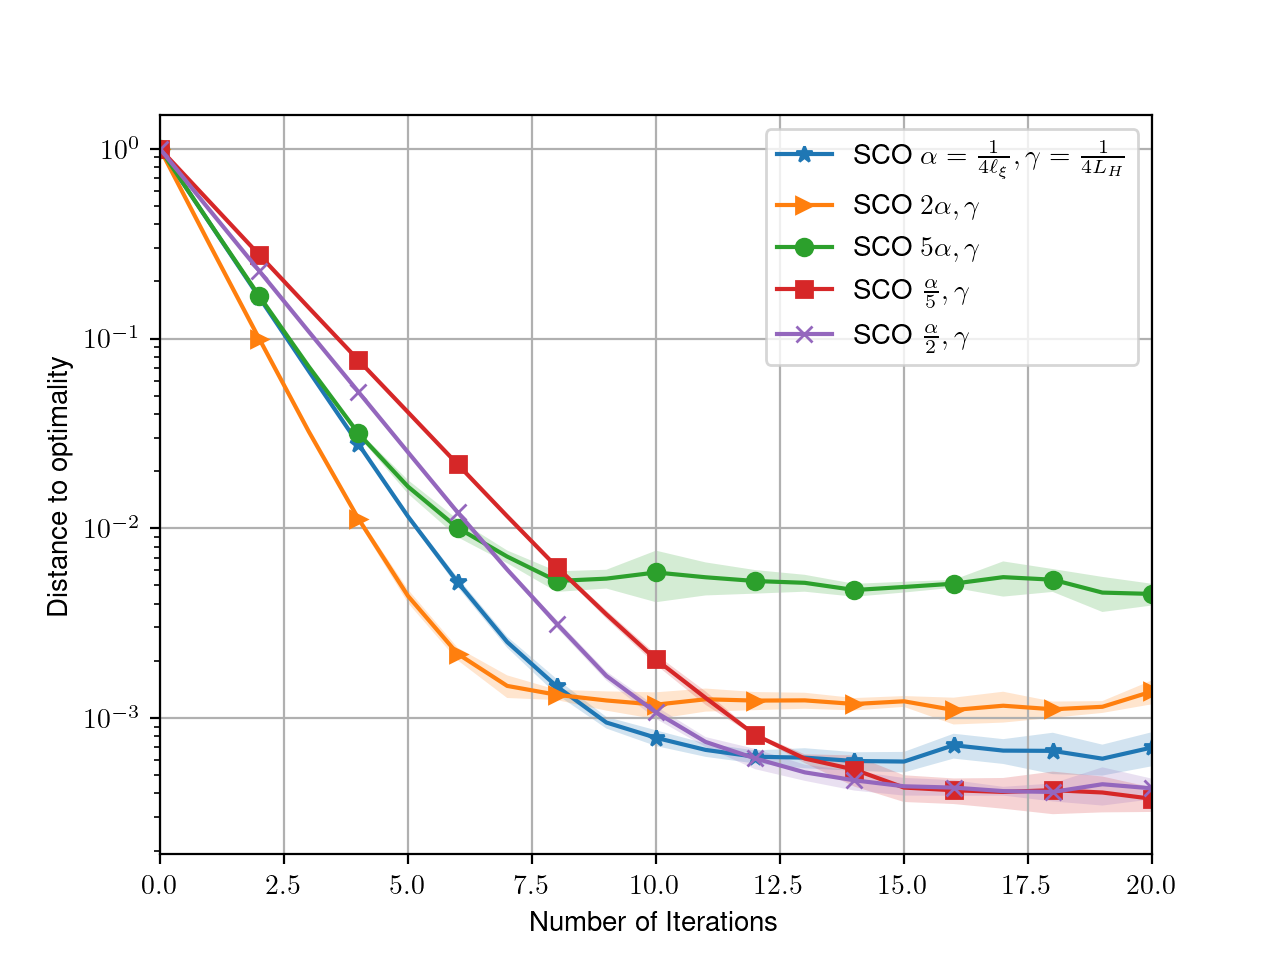

In [64]:
plt.figure()
plot(os.path.join(LOG_DIR, "SCO_alpha_small_1/*.json"), label=r"SCO $\alpha=\frac{1}{4\ell_\xi}, \gamma = \frac{1}{4L_H}$", marker="*", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_alpha_small_2/*.json"), label=r"SCO $2\alpha, \gamma$", marker=">", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_alpha_small_3/*.json"), label=r"SCO $5\alpha, \gamma$", marker="o", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_alpha_small_4/*.json"), label=r"SCO $\frac{\alpha}{5}, \gamma$", marker="s", markevery=2, normalize=True)
plot(os.path.join(LOG_DIR, "SCO_alpha_small_5/*.json"), label=r"SCO $\frac{\alpha}{2}, \gamma$", marker="x", markevery=2, normalize=True)

plt.legend()
plt.xlim(0, 20)
#plt.ylim(top=1)
plt.grid()
plt.savefig("figures/sco_alpha.pdf", format='pdf', bbox_inches='tight')